# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

In [2]:
# plotting
from matplotlib.patches import Rectangle
# pot distribution:
import scipy.stats as stats
# params = {
#     'axes.labelsize': 18,
#     'legend.fontsize': 18,
#     'xtick.labelsize': 16,
#     'ytick.labelsize': 16,
#     'text.usetex': True,
#     'figure.figsize': [7, 3.375],
#     'xtick.direction': 'in',
#     'ytick.direction': 'in',
#     'ytick.right': True,
#     'xtick.top': True
#    }
# plt.rcParams.update(params)

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

### Ring parameters

In [38]:
N = 8  # number of transmons
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (5, 4), (6, 5), (7, 6), (0, 7)]  # edges
architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

In [39]:
# from freq_allocation.parsing import *
# # parse the csd
# G = parse_csv("../solutions/juin/")
# architecture = "CR" 

In [40]:
# G.plot()

### Constructing a FrequencyGraph object

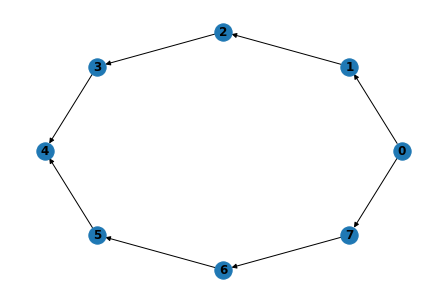

In [41]:
G = FrequencyGraph(edges=edges, cz=cz)
pos = {i: (np.cos(2*np.pi/N*i), (np.sin(2*np.pi/N*i))) for i in range(N)}
G.plot(pos = pos)

In [42]:
G.cz

False

In [43]:
#thresholds
if architecture == 'CR' and not qutrit:
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

elif (architecture == 'CR') and qutrit:
    d_dict = {'A1': 0.017,
              'A2i': 0.03,
              'A2j': 0.03,
              'A3i': 0.03,
              'A3j': 0.03,
              "E1": 0.017,
              "E2": 0.03,
              "E3": 0.03,
              "E4":0.002,
              "F1": 0.017,
              "F2":0.025,
              "F3": 0.025,
              "M1": 0.017}
    cr_keys = ['A1', 'A2i', 'A2j','A3i', 'A3j', "E1", "E2","E3", "E4",
               "C1", "C1b", "F1", "F2","F3",  "M1"]
    cstr_key = cr_keys
    
    
    
# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

In [44]:
d_dict

{'A1': 0.017,
 'A2i': 0.03,
 'A2j': 0.03,
 'E1': 0.017,
 'E2': 0.03,
 'E4': 0.002,
 'F1': 0.017,
 'F2': 0.025,
 'M1': 0.017}

## Optimization of the frequency

### optimization parameters

In [45]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=False,
                             all_differents=all_differents)

### Optimization

In [46]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
optimizer.second_pass()
result = optimizer.third_pass()

In [47]:
optimizer.wC

{'A1': 1,
 'A2i': 1,
 'A2j': 1,
 'E1': 1,
 'E2': 1,
 'E4': 1,
 'F1': 1,
 'F2': 1,
 'M1': 1,
 'C1': 1}

### Adding the results to the frequencyGraph

In [48]:
# # manually adding the frequencyes and the drives
# freqs = np.array([ 5.63, 5.55, 5.40, 5.25, 5.05, 5.15, 5.3, 5.43])
# freqs = np.array([ 5.794, 5.659, 5.478, 5.297, 5.115, 5.240, 5.421, 5.603])
# freqs = {k: freqs[k] for k in range(8)}
# anharms = {k: -0.310 for k in range(8)}
# drives =  {e: freqs[e[1]] for e in G.edges}

In [49]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)

The drive frequency are CR compatible


In [50]:
print(G.check_solution(d_dict, cstr=cstr_key))

11 11 11
True


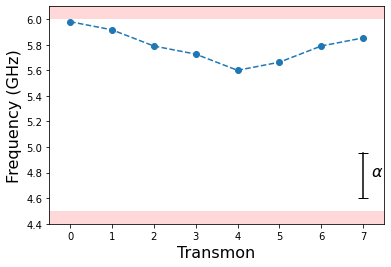

In [51]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.set_xlabel("Transmon", fontsize=16)
ax.set_ylabel("Frequency (GHz)", fontsize=16)
ax.add_patch(Rectangle((-0.5, 6.00), 8.0, 0.9,
        facecolor = 'Red',
        alpha= 0.15,
        fill=True,
        lw=5))

ax.add_patch(Rectangle((-0.5, 4.4), 8.0, 0.1,
        facecolor = 'Red',
        alpha= 0.15,
        fill=True,
        lw=5))

ax.set_ylim(4.4, 6.1)
ax.set_xlim(-0.5, 7.5)

ax.plot([7, 7], [4.6, 4.6+0.35], color='k', marker='_', markersize=10)
ax.text(7.2, 4.775, r"$\alpha$", fontsize=16)

fig.savefig("ring_optimized_freq.pdf")

In [52]:
for n in G:
    print(G.nodes[n])

{'freq': 5.98, 'a': -0.35}
{'freq': 5.916666666666696, 'a': -0.35}
{'freq': 5.790000000000057, 'a': -0.35}
{'freq': 5.72666666666675, 'a': -0.35}
{'freq': 5.600000000000111, 'a': -0.35}
{'freq': 5.663333333333415, 'a': -0.35}
{'freq': 5.790000000000054, 'a': -0.35}
{'freq': 5.853333333333361, 'a': -0.35}


In [53]:
# plotting
from matplotlib.patches import Rectangle
# pot distribution:
import scipy.stats as stats

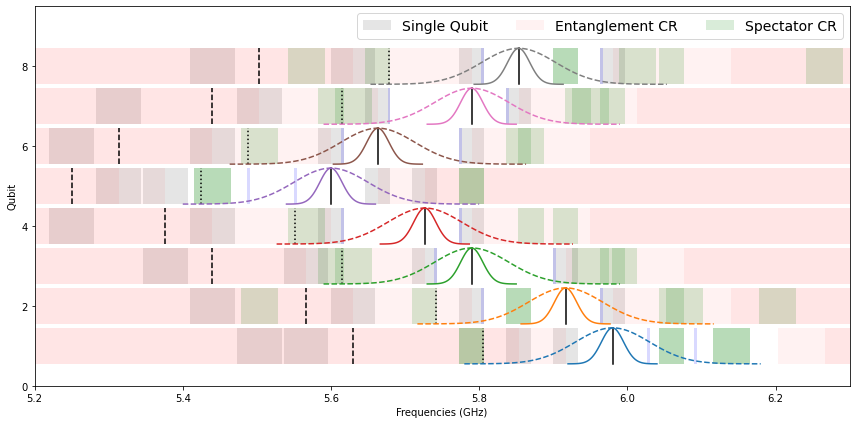

In [82]:
# sigma of the distribution of frequency
sigma = 0.02

fig, ax = plt.subplots(figsize=(12, 6))

# loop through the nodes
for n in G:
    
    #plot a dashed line at the position of the qubit frequencies
    ax.plot([G.nodes[n]['freq']]*2, [n+0.55,n+0.9+0.55], color='k', linestyle='-')
    ax.plot([G.nodes[n]['freq'] + G.nodes[n]['a']]*2, [n+0.55,n+0.9+0.55], color='k', linestyle='--')
    ax.plot([G.nodes[n]['freq'] + G.nodes[n]['a']/2]*2, [n+0.55,n+0.55 +.9], color='k', linestyle=':')
    
    ### Now the forbidden regions
    # Single qubits
    neighbors = [G.nodes[(n+1) % 8], G.nodes[(n-1) % 8]]
    for neighbor in neighbors:
        # A1
        ax.add_patch(Rectangle((neighbor['freq']-d_dict['A1'], n+0.55), 2*d_dict['A1'], 0.9,
                 facecolor = 'Gray',
                 alpha= 0.2,
                 fill=True))
        # A2
        ax.add_patch(Rectangle((neighbor['freq'] + neighbor['a']-d_dict['A2i'], n+0.55), 2*d_dict['A2i'], 0.9,
                                facecolor = 'Gray',
                               alpha= 0.2,
                               fill=True,
                               lw=5))
    
# Entanglements E1
for e in G.edges:
    i, j = e
    fj = G.nodes[j]['freq']
    fi = G.nodes[i]['freq']
    ai = G.nodes[i]['a']
# #     ax.add_patch(Rectangle((f-d_dict['E1'], i), 2*d_dict['E1'], 0.9,
# #                  facecolor = 'Blue',
# #                 alpha= 0.2,
# #                  fill=True,
# #                  lw=5))

#     ax.add_patch(Rectangle((fj-d_dict['E4']+ai/2, i+0.55), 2*d_dict['E4'], 0.9,
#              facecolor = 'Blue',
#             alpha= 0.2,
#              fill=True,
#              lw=5))
    
    
    #### C constraint
    ## fcontrol >= f target
    ax.add_patch(Rectangle((fj, i+0.55), -2.0, 0.9,
            facecolor = 'Red',
            alpha= 0.05,
            fill=True,
            lw=5))
    ax.add_patch(Rectangle((fi, j+0.55), 2.0, 0.9,
            facecolor = 'Red',
            alpha= 0.05,
            fill=True,
            lw=5)) 
    
    ## fcontrol+acontrol >= f target
    ax.add_patch(Rectangle((fj-ai, i+0.55), 2.0, 0.9,
            facecolor = 'Red',
            alpha= 0.05,
            fill=True,
            lw=5))
    ax.add_patch(Rectangle((fi+ai, j+0.55), -2.0, 0.9,
            facecolor = 'Red',
            alpha= 0.05,
            fill=True,
            lw=5)) 

    
    ## 2 photon transition: fj-fi-ai/2 >= delta
    ax.add_patch(Rectangle((fi+ai/2-d_dict['E4'], j+0.55), 2*d_dict['E4'], 0.9,
        facecolor = 'Blue',
        alpha= 0.15,
        fill=True,
        lw=5)) 

    ax.add_patch(Rectangle((fj-ai/2-d_dict['E4'], i+0.55), 2*d_dict['E4'], 0.9,
        facecolor = 'Blue',
        alpha= 0.15,
        fill=True,
        lw=5)) 

    
### Now the tricky contraint with 3 sites first the F constraints
for i, j, k in G.cr_neighbhors:
    ## F1: fj != fk
    fj = G.nodes[j]['freq']
    fi = G.nodes[i]['freq']
    fk = G.nodes[k]['freq']
    ak = G.nodes[k]['a']
    ak = G.nodes[i]['a']
    ax.add_patch(Rectangle((fk-d_dict['F1'], j+0.55), 2*d_dict['F1'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 
    ax.add_patch(Rectangle((fj-d_dict['F1'], k+0.55), 2*d_dict['F1'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 
    
    ## F2
    ax.add_patch(Rectangle((fk+ak-d_dict['F2'], j+0.55), 2*d_dict['F2'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 
    ax.add_patch(Rectangle((fj-ak-d_dict['F2'], k+0.55), 2*d_dict['F2'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 

    ## M1:
    ax.add_patch(Rectangle((fk-2*fi-ai-d_dict['M1'], j+0.55), 2*d_dict['M1'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 
    ax.add_patch(Rectangle((fj-2*fi-ai-d_dict['M1'], k+0.55), 2*d_dict['M1'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5)) 
    ax.add_patch(Rectangle(( (fj+fk-ai)/2-d_dict['M1'], i+0.55), 2*d_dict['M1'], 0.9,
        facecolor = 'Green',
        alpha= 0.15,
        fill=True,
        lw=5))     
    
for sigma, ls in zip([0.015, 0.05], ['-', '--']):

    for n in G.nodes:

        mu = G.nodes[n]['freq']
        x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)
        y /= np.max(y)
        ax.plot(x, n +0.55+ 0.9*y, color=f'C{n}', linestyle=ls)

                     
                     
# The legend. We will use dummy patches
ax.add_patch(Rectangle((0, 0), 0, 0, facecolor = 'Gray', alpha= 0.2,  fill=True, lw=5, label='Single Qubit'))
ax.add_patch(Rectangle((0, 0), 0, 0, facecolor = 'Red',  alpha= 0.05, fill=True, lw=5, label='Entanglement CR'))
ax.add_patch(Rectangle((0, 0), 0, 0, facecolor = 'Green',alpha= 0.15, fill=True, lw=5, label="Spectator CR"))  
ax.legend(ncol=3, loc=1, fontsize=14)

ax.set_xlabel('Frequencies (GHz)')
ax.set_ylabel('Qubit')

ax.set_xlim(5.2, 6.3)
ax.set_ylim(0, 9.5)



fig.tight_layout()
plt.savefig('visualization_8q_ring.pdf')

# np.sum(result[1])/np.float(result[1].shape[0])
#an even nicer visualization would be to map this into a ring. 

## Yield of the design

In [55]:
d_dict_qutrit = d_dict
d_dict_qubit = {key: d_dict[key] for key in  ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]}

In [56]:
# parametrization
Nsamples = 1e6
sigma = 0.060

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict_qutrit,
                                                       sigma=sigma,
                                                       cstr=cstr_key,
                                                       Nsamples=Nsamples, 
                                                      qutrit=True)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")

19 19 19
Qubit collisions:
yield   = 0.014959
average = 6.975676


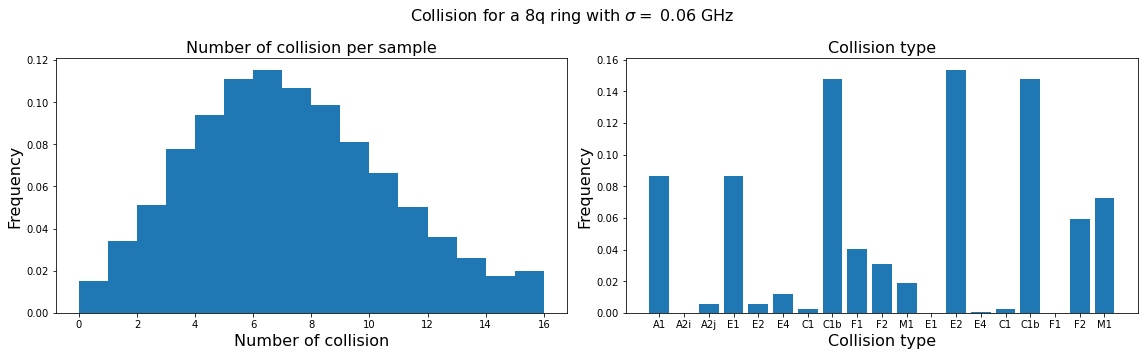

In [57]:
###### plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16],
        density=True)

#legend
ax.set_xlabel("Number of collision", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Number of collision per sample", fontsize=16)

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(constraints)

# legend and labels
ax.set_xlabel('Collision type', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title("Collision type", fontsize=16)
fig.suptitle(f"Collision for a {N}q ring with $\sigma=$ {sigma} GHz", fontsize=16)

fig.tight_layout()

fig.savefig("fig_collision_type.pdf")

11 11 11
Qubit collisions:
yield   = 0.014959
average = 6.975676
11 11 11
Qubit collisions:
yield   = 0.0116
average = 5.32271


Text(0.5, 0.98, 'Collision for a 8q ring with $\\sigma=$ 0.1 GHz')

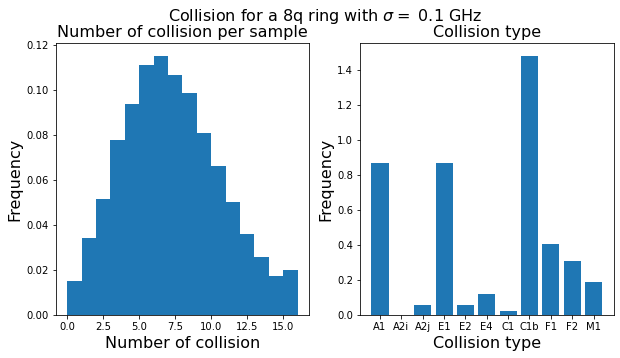

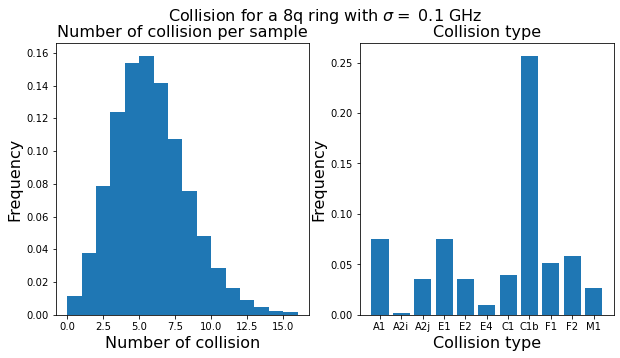

In [58]:
# parametrization
Nsamples = 100000
sigma = 0.100

# Calculating yield
collisions_3, c3, idx_list, constraints = G.get_collision(d_dict_qutrit,
                                                       sigma=sigma,
                                                       cstr=cstr_key,
                                                       Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")

###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16],
        density=True)

#legend
ax.set_xlabel("Number of collision", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Number of collision per sample", fontsize=16)

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title("Collision type", fontsize=16)
fig.suptitle(f"Collision for a {N}q ring with $\sigma=$ {sigma} GHz", fontsize=16)

# parametrization
Nsamples = 100000
sigma = 0.100

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict_qubit,
                                                       sigma=sigma,
                                                       cstr=cstr_key,
                                                       Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")

###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16],
        density=True)

#legend
ax.set_xlabel("Number of collision", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
ax.set_title("Number of collision per sample", fontsize=16)

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title("Collision type", fontsize=16)
fig.suptitle(f"Collision for a {N}q ring with $\sigma=$ {sigma} GHz", fontsize=16)


### Collision type distribution

### Collision spatial distribution

In [59]:
x = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
xm = [(x[i] + x[i+1])/2 for i in range(len(x)-1)]

Text(0.5, 0, 'Collision type')

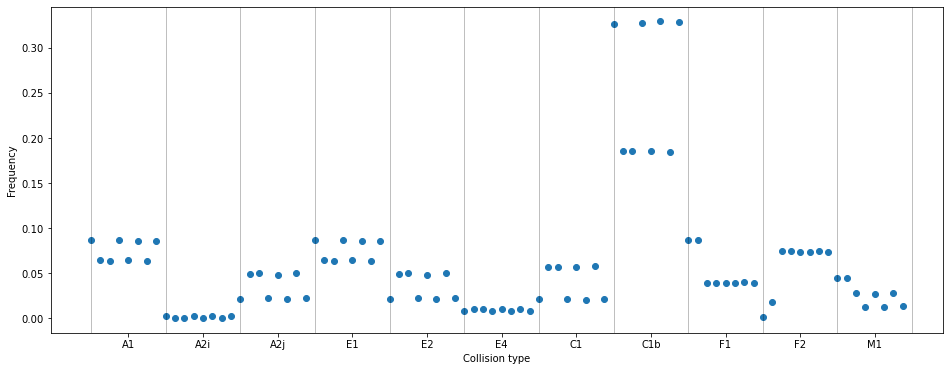

In [60]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.sum(~np.array(c), axis=1)/Nsamples, 'o')
for xx in x:
    ax.axvline(xx, color='k', linewidth=0.5, alpha = 0.5)
ax.set_xticks(xm);
ax.set_xticklabels(constraints)

ax.set_ylabel('Frequency')
ax.set_xlabel("Collision type")

### Collision vs std of the frequencies

In [61]:


# N_samples
Nsamples = 50000

# varying the dispersion of the frequency
# s_vec = np.linspace(1e-6, 0.1, 21)
s_vec = np.logspace(-2.5, -1, 21)

# Collision with all the constraints
collisions = np.array([G.get_collision(d_dict,
                                       Nsamples=Nsamples,
                                       sigma=s,
                                       cstr=cstr_key,
                                       qutrit=True)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

# collision with only the single qubits
collisions = np.array([G.get_collision(d_dict,
                                       Nsamples=Nsamples,
                                       sigma=s,
                                       cstr=['A1', 'A2i', 'A2j'])[0] for s in s_vec])
y0 = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

# collision with only the single qutrits
collisions = np.array([G.get_collision(d_dict,
                                       Nsamples=Nsamples,
                                       sigma=s,
                                       cstr=cstr_key,
                                       qutrit=False)[0] for s in s_vec])
y1 = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
19 19 19
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
3 3 3
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11
11 11 11


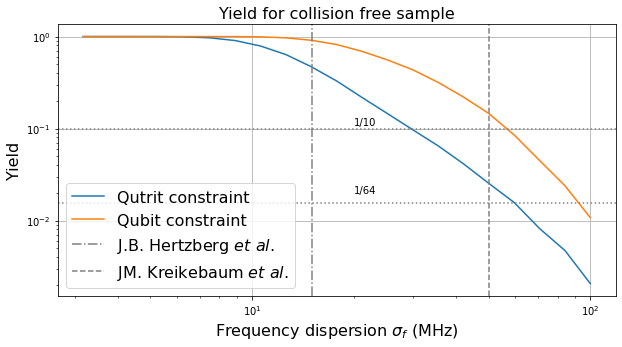

In [62]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))
ax.plot(s_vec*1e3, y[0], label=f'Qutrit constraint')
# ax.plot(s_vec*1e3, y0[0], label=f'1 Qubit constraint')
ax.plot(s_vec*1e3, y1[0], label=f'Qubit constraint')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

ax.axhline(1/64, ls=":", color='Gray')
ax.text(20, 2*1e-2, "1/64")
ax.axhline(1/10, ls=":", color='Gray')
ax.text(20, 1/10+0.01, "1/10")

# Legend and labels
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, loc=0. , fontsize=16)

# ax.set_xlim(0, 100)
ax.set_xscale("log")

ax.grid()
fig.savefig("fig_yield.pdf")

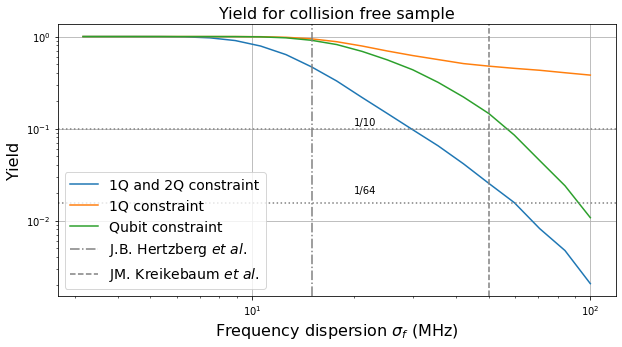

In [63]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))
ax.plot(s_vec*1e3, y[0], label=f'1Q and 2Q constraint')
ax.plot(s_vec*1e3, y0[0], label=f'1Q constraint')
ax.plot(s_vec*1e3, y1[0], label=f'Qubit constraint')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

ax.axhline(1/64, ls=":", color='Gray')
ax.text(20, 2*1e-2, "1/64")
ax.axhline(1/10, ls=":", color='Gray')
ax.text(20, 1/10+0.01, "1/10")

# Legend and labels
ax.set_ylabel(f'Yield', fontsize=16)
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)', fontsize=16)
ax.set_yscale('log')
ax.set_title('Yield for collision free sample', fontsize=16)
ax.legend(ncol=1, loc=0. , fontsize=14)

# ax.set_xlim(0, 100)
ax.set_xscale("log")

ax.grid()
fig.savefig("fig_yield.pdf")

In [11]:
params = {
    'axes.labelsize': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [7, 3.375],
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'ytick.right': True,
    'xtick.top': True
   }
plt.rcParams.update(params)

In [46]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield.npy',data)

In [12]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]
data_CZ = np.load('ring_8t_CZ_yield.npy', allow_pickle=True)[()]

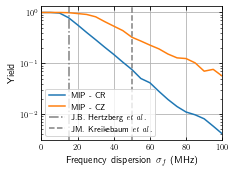

In [17]:
fig, ax = plt.subplots(figsize=(3.375, 2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data_CZ["sigma"]
y_cz = data_CZ["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=8, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

fig.savefig("fig_yield_ring.pdf")

In [53]:
data_CR

array({'sigma': array([0.     , 0.00125, 0.0025 , 0.00375, 0.005  , 0.00625, 0.0075 ,
       0.00875, 0.01   , 0.01125, 0.0125 , 0.01375, 0.015  , 0.01625,
       0.0175 , 0.01875, 0.02   , 0.02125, 0.0225 , 0.02375, 0.025  ,
       0.02625, 0.0275 , 0.02875, 0.03   , 0.03125, 0.0325 , 0.03375,
       0.035  , 0.03625, 0.0375 , 0.03875, 0.04   , 0.04125, 0.0425 ,
       0.04375, 0.045  , 0.04625, 0.0475 , 0.04875, 0.05   , 0.05125,
       0.0525 , 0.05375, 0.055  , 0.05625, 0.0575 , 0.05875, 0.06   ,
       0.06125, 0.0625 , 0.06375, 0.065  , 0.06625, 0.0675 , 0.06875,
       0.07   , 0.07125, 0.0725 , 0.07375, 0.075  , 0.07625, 0.0775 ,
       0.07875, 0.08   , 0.08125, 0.0825 , 0.08375, 0.085  , 0.08625,
       0.0875 , 0.08875, 0.09   , 0.09125, 0.0925 , 0.09375, 0.095  ,
       0.09625, 0.0975 , 0.09875, 0.1    ]), 'collisions': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 8, 5, ..., 3, 8, 3],
       [5, 4, 4

In [76]:
ord?

Signature: ord(c, /)
Docstring: Return the Unicode code point for a one-character string.
Type:      builtin_function_or_method
